# Ephemeris object imaging: continuum (mosaic gridder)

This nootebook demonstlates continuum imaging of the ephemeris objects. 
In the following steps first we use the attached ephemeris table(s) 

In [6]:
# extra packages needed
#import os
#os.system('pip install astropy')
#os.system('pip install aplpy')

In [8]:
# import helper functions defined in 'Trackfield' mfs mosaic notebook
from ipynb.fs.defs.ephemimagingVenusMfsMosaicTrackfield import *

In [9]:
from casatasks import getephemtable, tclean, exportfits, listobs, clearstat
from casatools import measures, quanta, table, image, msmetadata
import os
from astropy.io import fits
from matplotlib import pyplot
import pylab as pl
import aplpy
import shutil
me = measures()
qa = quanta()
tb = table()
ia = image()
msmd = msmetadata()

Define some useful funcitons
delete_tcleanimages: delete previous images from tclean run
get_attachedEphemtablepath: returns full eph table path for the corresponding field id

In [10]:
# import functions defined in trackfield notebook
#%run ephemimaging-venus-mfs-mosaic-trackfield.ipynb

In [11]:
#def delete_tcleanimages(imagename):
#    ''' clean up images from a previous run '''
#    imtypes = ['residual', 'image', 'psf', 'pb', 'model', 'sumwt','mask']
#    for type in imtypes:
#        if os.path.exists(f'{imagename}.{type}'):
#            os.system(f'rm -rf {imagename}.{type}')

In [12]:
#def get_attachedEphemtablepath(msfile, fieldid):
#    ''' returns full path of attached eph table for a specified field ID'''
#    import glob
#    tb.open(msfile+'/FIELD')
#    ephemid = tb.getcell('EPHEMERIS_ID',fieldid)
#    tb.close()
#    tabname = glob.glob(f'{msfile}/FIELD/EPHEM{ephemid}*/')
#    return os.path.abspath(tabname[0])

## 2) Imaging with epehemeris data attached to the MS by directly specifying the table for stopping the source
In order to track the ephemeris source during the observations, the proper ephemeris data is used. 
Ususally such ephemeris data table(s) are attached to the Measurement Set automatically during importadm when they are available. This demo shows one can explicitly specify the path of the internal ephemeris table in the phasecenter parameter. The result should be the same as phasecenter='TRACKFIELD' case.

In [13]:
datapath='/home/casa/data/casatestdata/measurementset/alma/'
# Use local data directory
#datapath='/Volumes/ssd1/casatestdata/measurementset/alma/'
#datapath='/Users/ttsutsum/SWDevel/ephemdemo/notebooks/'

In [14]:
msfile='venus_ephem_test.ms'
if os.path.exists(msfile):
    shutil.rmtree(msfile)
os.system(f'cp -r {datapath}{msfile} {msfile}')

0

In [15]:
imgname='mosaic-mfs-ineph-venus'

In [16]:
delete_tcleanimages(imgname)

In [17]:
ephemtab = get_attachedEphemtablepath(msfile, 0)
print(ephemtab)

/export/home/murasame2/casadev/ephemimaging/demo/notebooks/venus_ephem_test.ms/FIELD/EPHEM0_Venus_58491.4.tab


<b> It is important to set the absolute path of the table in phasecenter! </b>

In [18]:
ret=tclean(vis=msfile, field='Venus', imagename=imgname, imsize=[288, 288], cell=['0.14arcsec'], phasecenter=ephemtab, specmode='mfs', gridder='mosaic', usepointing=True, niter=100)
ret['iterdone']

refEp = Epoch: 58491::11:21:50.2080 : Direction: [-0.487327, -0.823033, -0.291769]
buildCoordSys : refCoord RA(rad) = 4.17779, Dec(rad) = -0.296076
2024-01-16 02:20:56	WARN	tclean::::casa	Warning! Non-zero values at the edge of the .pb image can cause unexpected aliasing effects! (found value 0.722619354724884 at index [284, 144, 0, 0])


100

### Convert a CASA image to FITS image for displaying the image via aplpy

Get the direction of Venus at the first timestamp of the select data from the ephemeris table

In [19]:
# Get the first time stamp 
msmd.open(msfile)
t0 = msmd.timesforfield(0)[0]
reftm=qa.quantity(t0,'s')
reftmcal = qa.time(reftm,form='ymd')
print(f'reftm:{reftmcal}')
msmd.done()
# find the direction of Venus at reftm
ineph_dir = ephem_dir(ephemtab, reftm,'ALMA')
print(ineph_dir)
ineph_rad = qa.convert(ineph_dir['m0'],'deg')
ineph_decd = qa.convert(ineph_dir['m1'],'deg')
inephmarker = {'ineph':{'ra':ineph_rad['value'], 'dec':ineph_decd['value']}}

reftm:['2019/01/08/11:23:28']
{'m0': {'unit': 'rad', 'value': -2.1053741432104243}, 'm1': {'unit': 'rad', 'value': -0.2960804428183449}, 'refer': 'ICRS', 'type': 'direction'}


INFO: Setting slices=[0, 0] [aplpy.core]


Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


INFO: Auto-setting vmin to -2.952e+00 [aplpy.core]
INFO: Auto-setting vmax to  2.998e+00 [aplpy.core]
ky=ineph
ineph at: 15:57:29.027, -016.57.50.975
image center: ('15:57:28.746', '-016.57.50.059')


<Figure size 1500x1500 with 0 Axes>

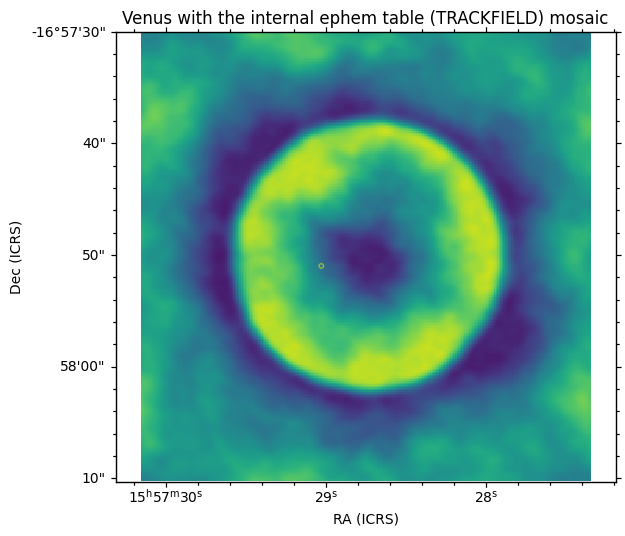

In [20]:
displayImage(imgname+'.residual', markers=inephmarker, title='Venus with the internal ephem table (TRACKFIELD) mosaic')

Image centered at a different position from what the ephemeris table gives!

In [23]:
print("internal ephem dir = ",qa.time(ineph_dir['m0'],prec=9),qa.angle(ineph_dir['m1'],prec=9))

internal ephem dir =  ['15:57:29.027'] ['-016.57.50.975']


In [24]:
printImageCenter(imgname+'.image')

('15:57:28.746', '-016.57.50.059')